In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Visualization imports
import seaborn as sns
%matplotlib inline
import plotly.express as px

#NLP imports
import spacy
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
import heapq
import re
import nltk
import networkx as nx
from gensim.models import word2vec

#Scikit Learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
#Reading Data
df = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [3]:
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(df)):
    review = re.sub(r"http\S+", "", df['text'][i]) # This code removes links from text
    review = re.sub('[^a-zA-Z\d+]', ' ', review) 
    review = re.sub('[0-9]', '', review) 
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word, pos = 'v') for word in review if not word in stopwords.words('english')]
    review = [lemmatizer.lemmatize(word, pos = 'n') for word in review]
    review = [lemmatizer.lemmatize(word, pos = 'a') for word in review] 
    review = ' '.join(review)
    corpus.append(review)

### Baseline Calculation

In [4]:
df['target'].value_counts(normalize = True)*100

0    57.034021
1    42.965979
Name: target, dtype: float64

##### If the model has an accuracy score of more than 57% then the model is doing better than a baseline

In [5]:
corpus[0]

'deed reason earthquake may allah forgive u'

##### Looking at the first line of corpus we can see that the data is clean

In [6]:
## Creating a Dictionary to see most frequent words
wordfreq = {}
for sentence in corpus:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [7]:
## Using heap module in python to see 10 most frequent words
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)
most_freq[0:10]

['get', 'like', 'fire', 'amp', 'go', 'u', 'bomb', 'new', 'via', 'one']

In [8]:
## create features for Bag of words manually, counter vectorizer can do this for us
sentence_vectors = []
for sentence in corpus:
    sentence_tokens = nltk.word_tokenize(sentence)
    sent_vec = []
    for token in most_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)
sentence_vectors = np.asarray(sentence_vectors)
sentence_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
#Instantiating Countervectorizer
cv = CountVectorizer(max_features=1000, ngram_range = (1,2))
X = cv.fit_transform(corpus).toarray()
y = df['target']

##### The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
[Ref](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [10]:
### Splitting data for training and test data and applying Naive Bayes Classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
clf = MultinomialNB().fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

In [11]:
print("Training set score using Naive Bayes Classifier: {:.2f}".format(clf.score(X_train, y_train)))
print("Testing set score using Naive Bayes Classifier: {:.2f}" .format(clf.score(X_test, y_test)))

Training set score using Naive Bayes Classifier: 0.81
Testing set score using Naive Bayes Classifier: 0.78


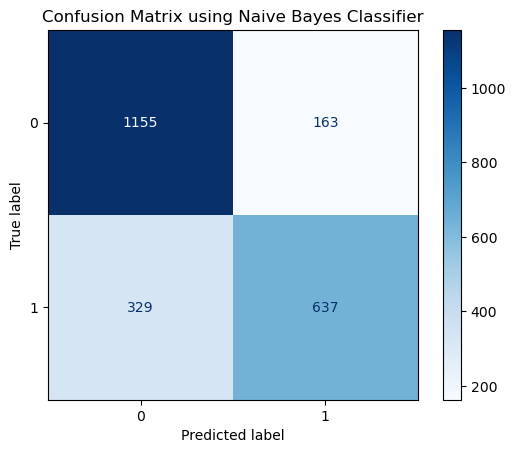

In [12]:
#Confusion matrix plot
plot_confusion_matrix(clf,X_test, y_test, cmap = 'Blues')
plt.title("Confusion Matrix using Naive Bayes Classifier");

##### This model predicts 329 False Negatives and 163 False Positive and the rest were predicted accurately and I used different parameter's like binary = true and ngram_range = (2,3) which resulted in less accuracy score

In [13]:
# Calculating Predicted Probabilities
y_pred_proba = clf.predict_proba(X_test)[:,1]
y_pred_proba

array([0.08683793, 0.00725147, 0.81240061, ..., 0.99955851, 0.99840222,
       0.0293491 ])

In [14]:
print(f'Accuracy score using Naive Bayes Classifier: {round(accuracy_score(y_test, y_pred_clf),2)}')
print(f'Recall score using Naive Bayes Classifier: {round(recall_score(y_test, y_pred_clf),2)}')
print(f'F1 score using Naive Bayes Classifier: {round(f1_score(y_test, y_pred_clf),2)}')
print(f'Precision score using Naive Bayes Classifier: {round(precision_score(y_test, y_pred_clf),2)}')

Accuracy score using Naive Bayes Classifier: 0.78
Recall score using Naive Bayes Classifier: 0.66
F1 score using Naive Bayes Classifier: 0.72
Precision score using Naive Bayes Classifier: 0.8


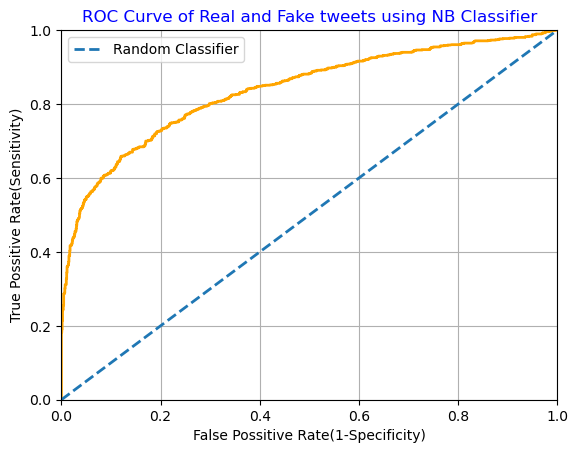

In [15]:
fpr,tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr,tpr, color = 'orange', lw =2)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC Curve of Real and Fake tweets using NB Classifier", color = 'blue')
plt.xlabel('False Possitive Rate(1-Specificity)')
plt.ylabel('True Possitive Rate(Sensitivity)')
plt.legend()
plt.grid(True)

In [16]:
print("The area under ROC CURVE using Naive Bayes {:.2f}".format(roc_auc_score(y_test, y_pred_proba)))

The area under ROC CURVE using Naive Bayes 0.84


##### We can see that the model is definitely performing better than the baseline model and the Area under the curve is 0.84. AUC ranges from 0 to 1. Higher AUC means better perfomance of model in differentiating possitive and negative classes

In [17]:
#Instantiating Logistic Regression Model
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Training Accuracy score using Logistic Regression:   {:.2f}'.format(train.score(X_train, y_train)))
print('Test Accuracy score:   {:.2f}'.format(train.score(X_test, y_test)))

Training Accuracy score using Logistic Regression:   0.85
Test Accuracy score:   0.79


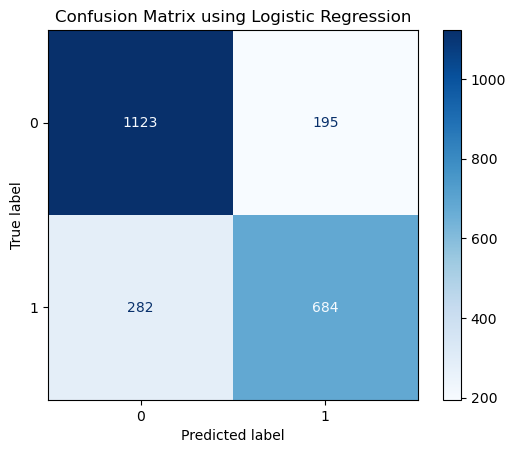

In [18]:
plot_confusion_matrix(lr, X_test, y_test, cmap = 'Blues')
plt.title("Confusion Matrix using Logistic Regression");

##### It appears from the confusion matrix that the logistic regression model is classifying better than the Naive Bayes model, here the model predicts 195 False positives and 277 False Negatives. The results are similar to Naive Bayes classifier but slightly better

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1318
           1       0.78      0.71      0.74       966

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284



##### The F1score, accuracy, precision and recall scores are also slightly better than Naive Bayes model

In [20]:
y_pred_proba_lr = lr.predict_proba(X_test)[:,1]
y_pred_proba_lr

array([0.11480409, 0.20913514, 0.72362715, ..., 0.99061128, 0.98863934,
       0.67170728])

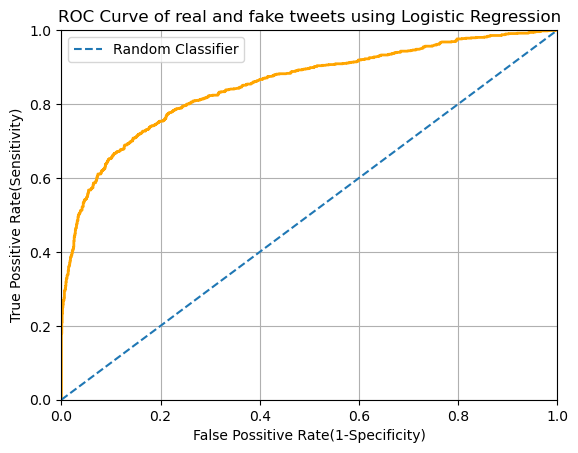

In [21]:
fpr,tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr,tpr, lw =2, color = 'orange')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC Curve of real and fake tweets using Logistic Regression")
plt.xlabel('False Possitive Rate(1-Specificity)')
plt.ylabel('True Possitive Rate(Sensitivity)')
plt.legend()
plt.grid(True)

In [22]:
print("The area under ROC CURVE using Logistic Regression {:.2f}".format(roc_auc_score(y_test, y_pred_proba_lr)))

The area under ROC CURVE using Logistic Regression 0.85


In [ ]:
#Instantiating Random grid for RFC
# Number of trees in random forest
n_estimators = [int(i) for i in np.linspace(100, 1100, 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Max number of levels in tree
max_depth = [None, 1,2,3,4,5,6,7]
# Minimum number of samples required to split a node
min_samples_split = [1,3,4,5,7,9]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4,6,8]
criterion = ['entropy', 'gini']
rf_grid = {'n_estimators' : n_estimators,
              'max_features': max_features,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'criterion' : criterion}

In [ ]:
rf1 = RandomForestClassifier()
rscv = RandomizedSearchCV(rf1, 
                          param_distributions = rf_grid, 
                          n_iter = 100,
                          cv = 5,
                          n_jobs = -1,
                          verbose =2,
                          random_state = 42)

In [ ]:
%%time
rscv.fit(X_train, y_train)
print(rscv.score(X_train, y_train))
print(rscv.score(X_test, y_test))

##### The Random Forest Clasifier with Randomseachcv took about 9 hours and the results were similar to previously performed Logistic Regression and Naive Bayes Models

In [ ]:
rscv.best_estimator_

In [23]:
#Instantiate RFC with GridsearchCV
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [400,500,600],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [2],
    'min_samples_split': [5]
}

In [24]:
%%time
gs = GridSearchCV(rf, param_grid=rf_params,
                  n_jobs = -1,
                  cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.7785686476583076
CPU times: user 12.5 s, sys: 324 ms, total: 12.8 s
Wall time: 2min 10s


{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 500}

In [25]:
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.8412460123850629
0.787215411558669


##### using the best hyperparametres from randomsearchcv, gridsearchcv results in same accuracy score

In [26]:
gs.best_estimator_.feature_importances_[1:5]

array([4.37733256e-05, 9.06048601e-03, 4.34896683e-05, 3.63048428e-04])

In [27]:
X_train_df = pd.DataFrame(X_train, 
                          columns=cv.get_feature_names())

In [28]:
X_train_df.columns

Index(['abc', 'ablaze', 'accident', 'across', 'act', 'action', 'actually',
       'add', 'affect', 'affect fatal',
       ...
       'year old', 'yes', 'yet', 'young', 'youth', 'youtube', 'youtube video',
       'yr', 'yr old', 'zone'],
      dtype='object', length=1000)

In [29]:
df1 = pd.DataFrame({'feature_names':X_train_df.columns,
                   'feature_importance':gs.best_estimator_.feature_importances_})

#Sort the DataFrame in order decreasing feature importance
df1.sort_values(by=['feature_importance'], ascending=False,inplace=True)

In [30]:
df1.set_index('feature_names', inplace = True)

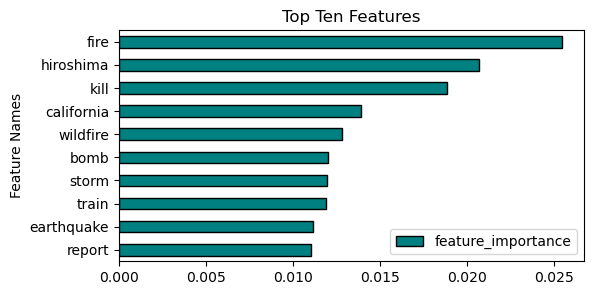

In [32]:
df1.sort_values(by = 'feature_importance', ascending = True).tail(10).plot(kind = 'barh', color = 'teal',
                                                                            edgecolor = 'black',
                                                                          figsize = (6,3))
plt.title("Top Ten Features")
plt.ylabel('Feature Names')
plt.savefig('../images/topfeatures.png');

In [33]:
df1.to_csv('../data/topfeatures..csv')

In [34]:
df1.head(10)

,feature_importance
feature_names,
fire,0.025451
hiroshima,0.020718
kill,0.018859
california,0.013905
wildfire,0.012830
bomb,0.012023
storm,0.011969
train,0.011887
earthquake,0.011173


In [35]:
df['corpus'] = corpus

In [36]:
X = df['corpus']
y = df['target']

In [37]:
lr = LogisticRegression()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                   random_state = 42, stratify = y)

In [39]:
#creating corpus for test data for predictions
corpus_test = []
for i in range(0, len(df_test)):
    review = re.sub(r"http\S+", "", df_test['text'][i])
    review = re.sub('[^a-zA-Z\d+]', ' ', review)
    review = re.sub('[0-9]', '', review)
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word, pos = 'v') for word in review if not word in stopwords.words('english')]
    review = [lemmatizer.lemmatize(word, pos = 'n') for word in review]
    review = [lemmatizer.lemmatize(word, pos = 'a') for word in review]
    review = ' '.join(review)
    corpus_test.append(review)

In [40]:
pipe1 = Pipeline([
    ('tf', TfidfVectorizer(max_features = 1000, ngram_range = (1,2), binary = True)),
    ('lr_cv', LogisticRegression(C = 1.5))
])

In [41]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('tf',
                 TfidfVectorizer(binary=True, max_features=1000,
                                 ngram_range=(1, 2))),
                ('lr_cv', LogisticRegression(C=1.5))])

In [42]:
print(f'Train Accuracy score using TFIDF Logistic Regression: {round(pipe1.score(X_train, y_train),3)}')
print(f'Test Accuracy score using TFIDF Logistic Regression: {round(pipe1.score(X_test, y_test),3)}')

Train Accuracy score using TFIDF Logistic Regression: 0.839
Test Accuracy score using TFIDF Logistic Regression: 0.799


In [43]:
with open('../models/logistic_tfidf.pkl', 'wb') as f:
    pickle.dump(pipe1, f)

In [44]:
corpus_test[0]

'happen terrible car crash'

In [45]:
#Predicting on test set
pipe1.predict(corpus_test)[0]

1

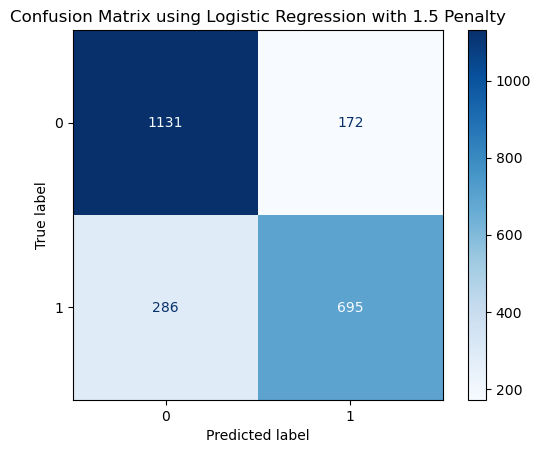

In [46]:
plot_confusion_matrix(pipe1, X_test, y_test, cmap = 'Blues')
plt.title("Confusion Matrix using Logistic Regression with 1.5 Penalty");

##### The Logistic Regression model  using TFIDF vectorizer with 100 max features, ngram range of 1,2, l2 penalty with a regularization strength of 1.5 performed similar to our other models and predicted 172 False Positives, 286 False Negatives

In [47]:
y_predlr = pipe1.predict(X_test)
y_predlr

array([1, 1, 0, ..., 0, 1, 0])

In [48]:
#Checking whether various thresholds can make a difference to our model
my_threshold = 0.6
y_preds_tr2 = (y_predlr > my_threshold)
confusion_matrix(y_test, y_preds_tr2)

array([[1131,  172],
       [ 286,  695]])

##### There is no difference in prediction after changing the threshold to 0.6 and above

In [49]:
#Checking whether various thresholds can make a difference to our model
my_threshold = 0.6
y_preds_tr2 = (y_predlr < my_threshold)
confusion_matrix(y_test, y_preds_tr2)

array([[ 172, 1131],
       [ 695,  286]])

##### Changing the threshold to 0.6 and below effected the model and it completely reversed the model predictions. It appears that changing the thresholds does not help our model predictions

In [50]:
pipe1.predict_proba(corpus_test)

array([[0.17504816, 0.82495184],
       [0.40654512, 0.59345488],
       [0.23780159, 0.76219841],
       ...,
       [0.36477659, 0.63522341],
       [0.19210227, 0.80789773],
       [0.61464961, 0.38535039]])

In [51]:
corpus_test[0]

'happen terrible car crash'

In [52]:
pipe1.predict(corpus_test)[0]

1

##### It appears that our above model predicts "happen terrible car crash" as real Disaster

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,
                                                   random_state = 42)

In [54]:
#Creating a Pipeline with XGBoost Classifier
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', XGBClassifier())
])

In [55]:
pipe2_params = {
    'cvec__max_features': [500, 1000, 2_000, 3_000],
    'cvec__min_df': [0,1],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'xgb__n_estimators': [100, 200, 300, 600],
    'xgb__max_depth': [None, 1, 2, 3]
    
}

# Instantiate GridSearchCV.

gs1= GridSearchCV(pipe2, 
                  n_jobs = -1,
                  param_grid = pipe2_params,
                  cv = 5)

In [56]:
%%time
gs1.fit(X_train, y_train)
print(f'Training Accuracy Score using XGBoost Classifier is : {round(gs1.score(X_train, y_train),2)}')
print("----------------")
print(f'Testing Accuracy Score using XGBoost Classifier is : {round(gs1.score(X_test, y_test),2)}')


Training Accuracy Score using XGBoost Classifier is : 0.87
----------------
Testing Accuracy Score using XGBoost Classifier is : 0.8
CPU times: user 15.8 s, sys: 1.11 s, total: 16.9 s
Wall time: 4min 28s


In [57]:
#Best Estimator
gs1.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=1000, min_df=0,
                                 ngram_range=(1, 2))),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_wei

##### max_df is the upper ceiling value of the frequency values, while min_df is just the lower cutoff value of the frequency values. If we want to remove more common words, we set max_df to a lower ceiling value between 0 and 1. If we want to remove more rare words, we set min_df to a higher cutoff value between 0 and 1

In [58]:
#Instantiating Countervectorizer
tf = TfidfVectorizer(max_df=0.9, max_features=1000, min_df = 1,
                                 ngram_range=(1, 2))
X = tf.fit_transform(corpus).toarray()
y = df['target']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, 
                                                    random_state = 42,
                                                   stratify = y)

##### After each boosting step, we can directly get the weights of new features, and 'eta' shrinks the feature weights to make the boosting process more conservative. The larger gamma is, the more conservative the algorithm will be.range: [0,∞]. Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees.

In [60]:
xgb = XGBClassifier(n_estimators = 2000, eta = 0.3, gamma = 5, max_depth = 8, subsample = 0.5)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [61]:
print(round(xgb.score(X_train, y_train),3))
print(round(xgb.score(X_test, y_test),3))

0.861
0.782


##### The XGBoost Classifier with TFIDF Vectorizer has a high accuracy score of 86% and a test accuracy of 78% and it is clear from the scores that the model is overfitting

In [62]:
#Creating a Dataframe to get feature names
X_train_df1 = pd.DataFrame(X_train, 
                          columns= tf.get_feature_names())

In [63]:
df2 = pd.DataFrame({'feature_names':X_train_df1.columns,
                   'feature_importance':xgb.feature_importances_})

#Sort the DataFrame in order decreasing feature importance
df2.sort_values(by=['feature_importance'], ascending=False,inplace=True)
df2.head()

,feature_names,feature_importance
554,mh,0.011397
419,hiroshima,0.007714
948,warn,0.007115
465,israeli,0.006992
887,train,0.006133


In [64]:
#Setting feature names as index to the dataframe
df2.set_index('feature_names', inplace = True)

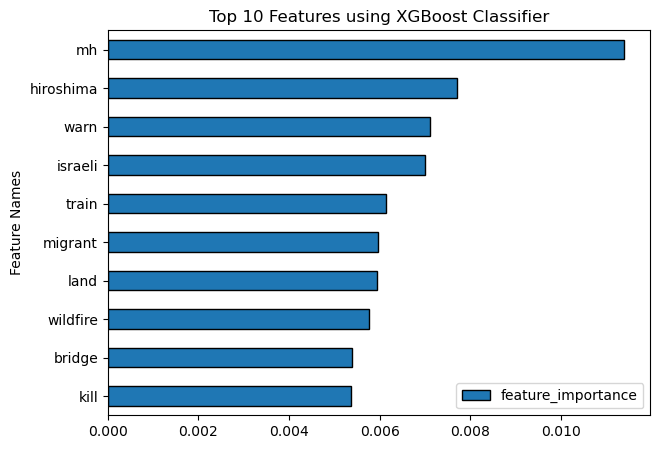

In [65]:
df2.sort_values(by = 'feature_importance', ascending = True).tail(10).plot(kind = 'barh', 
                                                                           edgecolor = 'black',
                                                                          figsize = (7,5))
plt.ylabel('Feature Names')
plt.title("Top 10 Features using XGBoost Classifier");

In [66]:
with open('../models/xgboost_cv', 'wb') as f:
    pickle.dump(xgb, f)

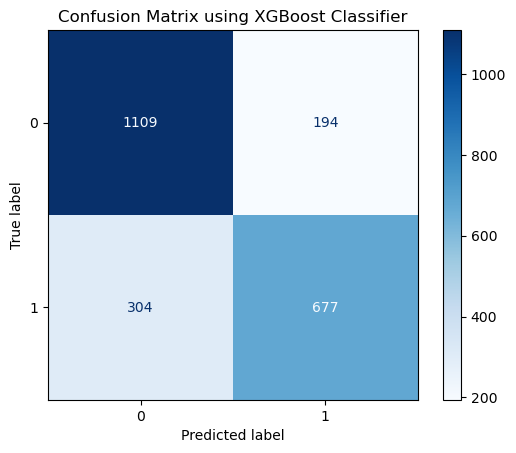

In [67]:
#Confusion matrix plot
plot_confusion_matrix(xgb,X_test, y_test, cmap = 'Blues')
plt.title("Confusion Matrix using XGBoost Classifier");

In [68]:
X = tf.fit_transform(corpus).toarray()
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, 
                                                    random_state = 42,
                                                   stratify = y)

In [69]:
#Logistic Regression with l1 penalty
lrcv = LogisticRegression(solver = 'newton-cg', penalty = 'l2', C = 1)
lrcv.fit(X_train, y_train)
print(f'Training Score: {round(lrcv.score(X_train, y_train),2)}')
print(f'Testing SCore: {round(lrcv.score(X_test, y_test),2)}')

Training Score: 0.83
Testing SCore: 0.8


##### The logistic regression model with newton-cg solver, l2 penalty with a regularization of 1 with TFIDF vectorizer has accuracy similar to previous models 

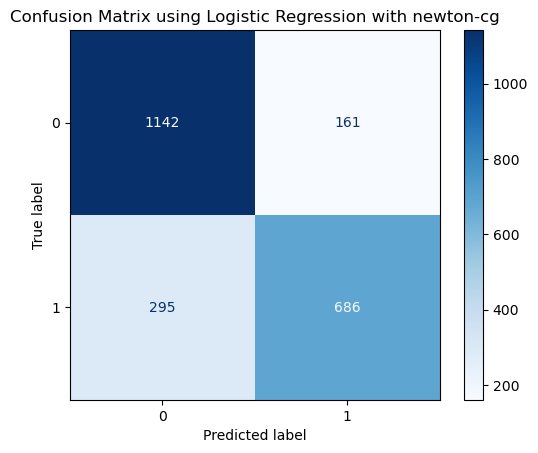

In [70]:
#Generating a confusion matrix plot using the logisticregression with l1 penalty
plot_confusion_matrix(lrcv, X_test, y_test, cmap = 'Blues')
plt.title("Confusion Matrix using Logistic Regression with newton-cg");

In [77]:
X = cv.fit_transform(corpus).toarray()
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, 
                                                    random_state = 42,
                                                   stratify = y)

In [89]:
#Logistic Regression with l2 penalty
lrcv1 = LogisticRegression(solver = 'liblinear', penalty = 'l2', C = 1)
lrcv1.fit(X_train, y_train)
print(f'Accuracy Train score using Logistic Regression with L2 penalty is :{round(lrcv1.score(X_train, y_train),3)}')
print('---------------')
print(f'Accuracy Test score using Logistic Regression with L2 penalty is :{round(lrcv1.score(X_test, y_test),3)}')


Accuracy Train score using Logistic Regression with L2 penalty is :0.853
---------------
Accuracy Test score using Logistic Regression with L2 penalty is :0.799


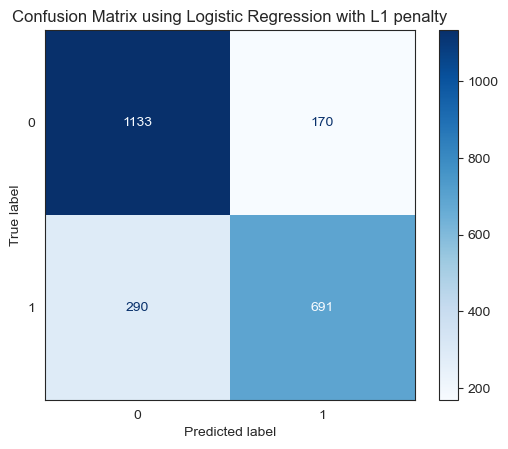

In [88]:
#Generating a confusion matrix plot using the logisticregression with l1 penalty
plot_confusion_matrix(lrcv1, X_test, y_test, cmap = 'Blues')
plt.title("Confusion Matrix using Logistic Regression with L1 penalty");

##### We can see that there are 109 False positives and 334 False negatives in our predicted model, we can try to balance these errors by increasing or decreasing the thresholds

In [73]:
ypreds = lrcv1.predict(X_test)

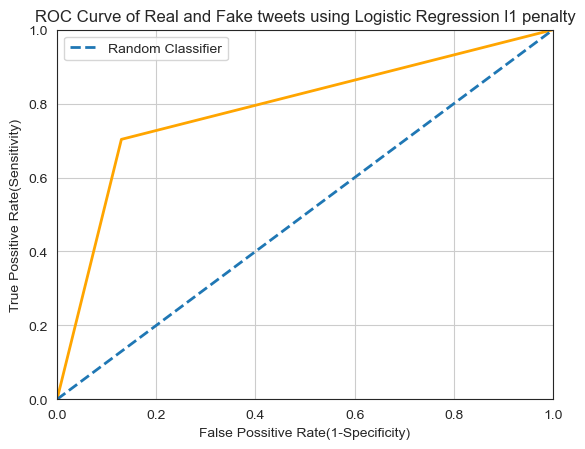

In [74]:
sns.set_style('white')
fpr,tpr, thresholds = roc_curve(y_test, ypreds)
plt.plot(fpr,tpr, color = 'orange', lw = 2)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC Curve of Real and Fake tweets using Logistic Regression l1 penalty")
plt.xlabel('False Possitive Rate(1-Specificity)')
plt.ylabel('True Possitive Rate(Sensitivity)')
plt.legend()
plt.grid(True)

In [75]:
print(classification_report(y_test, ypreds))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1303
           1       0.80      0.70      0.75       981

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [76]:
my_threshold = 0.6
y_preds_tr = (lrcv1.predict(X_test) > my_threshold).astype(int)
confusion_matrix(y_test, y_preds_tr)

array([[1134,  169],
       [ 291,  690]])

### Conclusion

#### The kaggle dataset was loaded and cleaned using Regular Expressions, lemmatization. The data was analyzed by calculating the text length, word lengths and visualizing the columns. The average text length was around 100 and average word count was around 15. Data was then divided into two separate datasets based on the target column to analyze and visualize frequent words in real and fake tweets. It appears that similar words have been used in both real disaster tweets and fake tweets. Data was then modeled using NLP techniques like TFIDF vectorizer and Countervectorizer and various Supervised learning models starting with a simple logistic regression, Naive Bayes Classifier, Random Forest, XGBoost Classifier and ended with regularizing a logistic regression model. Models were trained and tested with 70% training and 30% testing data. Models were rigorously evaluated with metrics like accuracy, precision, recall, specificity. AUC curves were plotted, hyperparameter tuning was performed on models like Randomforest and XGBoost. Confusion matrix was plotted for every model, increased and decreased thresholds to see how the model performed at different thresholds. 

####  This model not only helps in flagging fake tweets, it is also helpful to identify real tweets and assist people who are in need of help. Once a model is deployed into production and providing utility to the business, it is necessary to monitor how well the model is performing to implement something that will continuously update the database as new data is generated. We can use a scalable messaging platform like Kafka to send newly acquired data to a long running Spark Streaming process. The Spark process can then make a new prediction based on the new data and update the operational database. 

#### Most of the models had an accuracy of about 80% on test score, however, because of the similarity of the words used in both real and fake tweets more data is required for our Machine learning models to classify these tweets with high accuracy